In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import tensorflow as tf


2022-09-07 15:13:16.024136: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-07 15:13:16.224342: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-07 15:13:17.094098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-07 15:13:17.094175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
tf.keras.backend.clear_session()

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


2022-09-07 15:13:18.045320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-07 15:13:18.626687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1172 MB memory:  -> device: 0, name: Quadro K620, pci bus id: 0000:01:00.0, compute capability: 5.0


In [5]:
model = ResNet50(weights='imagenet')

In [6]:
img = image.load_img('img.jpg', target_size=(224, 224))

In [7]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

2022-09-07 15:13:22.706897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500
2022-09-07 15:13:23.053151: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-07 15:13:23.178016: I tensorflow/stream_executor/cuda/cuda_driver.cc:733] failed to allocate 918.69M (963313664 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


1/1 [==============================] - 3s 3s/step
Predicted: [('n01443537', 'goldfish', 0.9999708), ('n01440764', 'tench', 1.8493682e-05), ('n02514041', 'barracouta', 6.03033e-06)]


2022-09-07 15:13:24.101498: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


## Getting the dataset

In [8]:
import os

base_dir = '/home/lion/Documents/Ignacio_Vazquez/AI2/zaldivar/practica_2/dataset/'
train_dir = os.path.join(base_dir, 'training_set')
validation_dir = os.path.join(base_dir, 'test_set')

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150))
val_dataset = image_dataset_from_directory(validation_dir,
                                                shuffle=True,
                                                batch_size=32,
                                                image_size=(150, 150))

Found 906 files belonging to 5 classes.
Found 453 files belonging to 5 classes.


In [10]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.9),
    ]
)

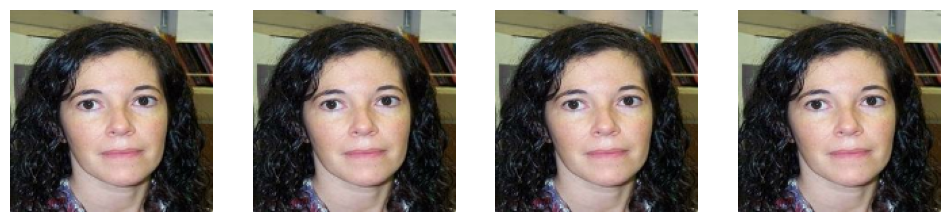

In [11]:
import numpy as np
import matplotlib.pyplot as plt
for images, labels in training_set.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(4):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0)
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

###########################

In [12]:
learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0003, 
                                                                         decay_steps=2, 
                                                                         decay_rate=0.97, 
                                                                         staircase=False)

In [13]:
def dense_net_model(trainable_weights=False, weights_path=None):
    
    tf.keras.backend.clear_session()
    
    dense_net = keras.applications.DenseNet201(input_shape=(150, 150, 3), weights="imagenet", include_top=False)
    
    for layer in dense_net.layers:
        layer.trainable=trainable_weights
    
    # model = tf.keras.models.Sequential([dense_net,
    #                                     tf.keras.layers.GlobalAveragePooling2D(),
    #                                     tf.keras.layers.Dense(128, activation='relu'),
    #                                     tf.keras.layers.Dropout(0.3),
    #                                     tf.keras.layers.Dense(5, activation='softmax')
    #                             ])
        
    model = tf.keras.Sequential([
            base_model,  
            tf.keras.layers.BatchNormalization(renorm=True),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(512, activation='relu'),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(5, activation='softmax')
        ])

    if weights_path:
        model.load_weights(weights_path)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler)
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [14]:
dense_net_transfer = dense_net_model(trainable_weights=True)
dense_net_transfer_history = dense_net_transfer.fit(training_set, validation_data=val_dataset, epochs=25, steps_per_epoch=32)

NameError: name 'base_model' is not defined

#########################################

In [ ]:
base_model = keras.applications.Xception(
    weights='imagenet',  
    input_shape=(150, 150, 3),
    include_top=False)  
    
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(150, 150, 3))

In [ ]:
x = data_augmentation(inputs)

In [ ]:
x = tf.keras.applications.xception.preprocess_input(x)

In [ ]:
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
# learning rate decay
learning_rate_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0003, 
                                                                         decay_steps=2, 
                                                                         decay_rate=0.97, 
                                                                         staircase=False)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_scheduler),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(training_set, epochs=20, validation_data=val_dataset)

Epoch 1/20
29/29 [==============================] - 20s 617ms/step - loss: 1.8960e-07 - accuracy: 0.3962 - val_loss: 1.9052e-07 - val_accuracy: 0.4238
Epoch 2/20
29/29 [==============================] - 19s 646ms/step - loss: 1.8960e-07 - accuracy: 0.3742 - val_loss: 1.9052e-07 - val_accuracy: 0.4238
Epoch 3/20
29/29 [==============================] - 18s 637ms/step - loss: 1.8960e-07 - accuracy: 0.4007 - val_loss: 1.9052e-07 - val_accuracy: 0.4238
Epoch 4/20
29/29 [==============================] - 17s 605ms/step - loss: 1.8960e-07 - accuracy: 0.3764 - val_loss: 1.9052e-07 - val_accuracy: 0.4238
Epoch 5/20
29/29 [==============================] - 15s 504ms/step - loss: 1.8960e-07 - accuracy: 0.3929 - val_loss: 1.9052e-07 - val_accuracy: 0.4238
Epoch 6/20
29/29 [==============================] - 14s 490ms/step - loss: 1.8960e-07 - accuracy: 0.3830 - val_loss: 1.9052e-07 - val_accuracy: 0.4238
Epoch 7/20
29/29 [==============================] - 14s 480ms/step - loss: 1.8960e-07 - accura